In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Load and prepare data
df = pd.read_csv('/content/drive/MyDrive/final_ds.csv')
texts = df['CleanedText'].fillna('').values
labels = df['Hate'].values


In [6]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize texts
encoded_texts = tokenizer(
    list(texts),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Convert to PyTorch tensors
input_ids = encoded_texts['input_ids']
attention_masks = encoded_texts['attention_mask']
labels = torch.tensor(labels)

In [8]:
# Split data
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42
)
train_masks, val_masks, _, _ = train_test_split(
    attention_masks, labels, test_size=0.2, random_state=42
)

# Create dataloaders
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)


In [9]:
# Initialize model for binary classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification: 2 labels
    output_attentions=False,
    output_hidden_states=False,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Average training loss: {avg_train_loss}")

    # Validation
    model.eval()
    val_preds, val_labels_list = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_labels_list, val_preds)
    print(f"Epoch {epoch+1}, Validation accuracy: {val_accuracy:.4f}")

model_save_path = '/content/drive/MyDrive/saved_complete_bert_model.pth'


100%|██████████| 1100/1100 [10:49<00:00,  1.69it/s]


Epoch 1, Average training loss: 0.252968562299555
Epoch 1, Validation accuracy: 0.9232


100%|██████████| 1100/1100 [10:50<00:00,  1.69it/s]


Epoch 2, Average training loss: 0.15450984242033552
Epoch 2, Validation accuracy: 0.9504


100%|██████████| 1100/1100 [10:50<00:00,  1.69it/s]


Epoch 3, Average training loss: 0.08479525165251371
Epoch 3, Validation accuracy: 0.9666


100%|██████████| 1100/1100 [10:50<00:00,  1.69it/s]


Epoch 4, Average training loss: 0.04574592518778941
Epoch 4, Validation accuracy: 0.9756


100%|██████████| 1100/1100 [10:50<00:00,  1.69it/s]


Epoch 5, Average training loss: 0.02904804276582912
Epoch 5, Validation accuracy: 0.9753


In [16]:
# Save the entire model (architecture + weights)
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")

# Load model for testing
# Instead of loading from pretrained, load the saved model directly
model = torch.load(model_save_path)
model.to(device)
model.eval()


Model saved to /content/drive/MyDrive/saved_complete_bert_model.pth


<ipython-input-16-76b55b39b466>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_path)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:

# Testing on a single example
test_text = "You Mother Father Bad Manners"  # example input
encoded_test = tokenizer(
    test_text,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)
input_ids_test = encoded_test['input_ids'].to(device)
attention_mask_test = encoded_test['attention_mask'].to(device)

with torch.no_grad():
    output = model(input_ids_test, attention_mask=attention_mask_test)
    prediction = torch.argmax(output.logits, dim=1).item()

print(f"Prediction for the input text '{test_text}': {'Hate' if prediction == 1 else 'Not Hate'}")


Prediction for the input text 'You Mother Father Bad Manners': Hate


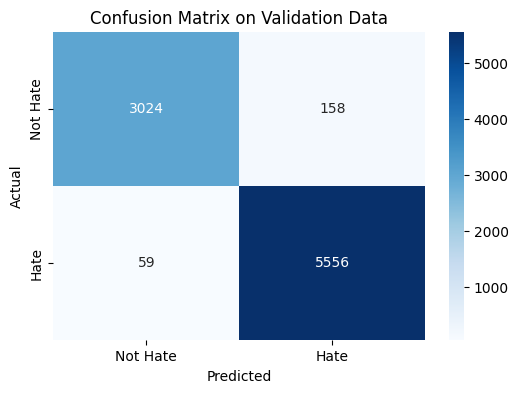

In [18]:
# Confusion Matrix on Validation Data
conf_matrix = confusion_matrix(val_labels_list, val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hate", "Hate"], yticklabels=["Not Hate", "Hate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Data")
plt.show()